# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Answer: The RTX 3090 graphics card has 10496 CUDA cores.

Question 2: How much memory does the graphics card have?

Answer: The Nvidia GeForce RTX 3090 graphics card has 24 GB of GDDR6X memory.

Question 3: What is stored in the GPU memory while training a DNN ?

Answer: The GPU memory stores all the necessary data for forward and backward passes of the DNN during training, such as, input data, gradients, model parameters and activation outputs.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [2]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data_half.npy')
Y = np.load('Mirai_labels_half.npy')



# Remove the first 24 covariates (columns)
X_new = np.delete(X, range(24), 1)

print('The covariates have size {}.'.format(X_new.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
    

The covariates have size (382069, 92).
The labels have size (382069,).


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

Answer: It depends on the class distribution of the dataset. Assuming that the dataset has N samples, and C classes, the accuracy of the naive classifier will then be:

The most common class C1 having x number of samples, then the accuracy, A = x/N.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [3]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
# X_new[np.isnan(X_new) == True]

# Print the number of NaNs (not a number) in the labels
print('The number of NaNs in the labels are: ',len(Y[np.isnan(Y) == True]))

# Print the number of NaNs in the covariates
print('The number of NaNs in the covariates are: ',np.count_nonzero(np.isnan(X_new)))

The number of NaNs in the labels are:  0
The number of NaNs in the covariates are:  0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [4]:
# Convert covariates to floats

X_new = X_new.astype('float64')
# Convert labels to integers

Y = Y.astype('int')

# Remove mean of each covariate (column)
mean_x = np.mean(X_new,axis=0)
X_new = X_new - mean_x

# Divide each covariate (column) by its standard deviation
std_x = np.std(X_new, axis = 0)
X_new = X_new/std_x
X_new
# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print('The mean of the covariates is: ',np.round(np.mean(X_new, axis = 0)))
print('The standard deviation of the covariates is: ',np.std(X_new, axis = 0))

The mean of the covariates is:  [ 0.  0.  0. -0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0. -0. -0. -0.  0.
  0. -0. -0. -0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0.
 -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
 -0.  0. -0.  0. -0. -0. -0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.
 -0. -0. -0.  0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0.]
The standard deviation of the covariates is:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [5]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X_new, Y, test_size=0.3, train_size=0.7, random_state=42)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
print('The number of examples from class 0 in training data: ', len(np.where(Ytrain==0)[0]))
print('The number of examples from class 1 in training data: ', len(np.where(Ytrain==1)[0]))

print('The number of examples from class 0 in temp data: ', len(np.where(Ytemp==0)[0]))
print('The number of examples from class 1 in temp data: ', len(np.where(Ytemp==1)[0]))

Xtrain has size (267448, 92).
Ytrain has size (267448,).
Xtemp has size (114621, 92).
Ytemp has size (114621,).
The number of examples from class 0 in training data:  42583
The number of examples from class 1 in training data:  224865
The number of examples from class 0 in temp data:  18228
The number of examples from class 1 in temp data:  96393


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [6]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, train_size=0.5, random_state=42)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (57310, 92), (57311, 92), (57310,) and (57311,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from keras.losses import BinaryCrossentropy

In [8]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy



# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate) 
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    model.add(Input(shape = input_shape[1]))
    # Add first layer, requires input shape
    model.add(Dense(n_nodes))
    model.add(Activation(act_fun))
    if use_dropout == True:
        model.add(Dropout(rate=0.5))
    elif use_custom_dropout == True:
        model.add(myDropout(rate=0.5))
    if use_bn == True:
        model.add(BatchNormalization())
    # # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        
        model.add(Dense(n_nodes))
        model.add(Activation(act_fun))
        if use_dropout == True:
            model.add(Dropout(rate=0.5))
        elif use_custom_dropout == True:
            model.add(myDropout(rate=0.5))
        if use_bn == True:
            model.add(BatchNormalization())
        
           
    
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss=binary_crossentropy, optimizer=opt, metrics=['accuracy'])
    
    return model

In [9]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [10]:
Xtrain.shape

(267448, 92)

In [11]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape

# Build the model
model1 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data = (Xval, Yval))

Epoch 1/20
27/27 [==============================] - 1s 11ms/step - loss: 0.4695 - accuracy: 0.8408 - val_loss: 0.4333 - val_accuracy: 0.8411
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.4278 - accuracy: 0.8408 - val_loss: 0.4206 - val_accuracy: 0.8411
Epoch 3/20
27/27 [==============================] - 0s 6ms/step - loss: 0.4147 - accuracy: 0.8408 - val_loss: 0.4067 - val_accuracy: 0.8411
Epoch 4/20
27/27 [==============================] - 0s 6ms/step - loss: 0.3994 - accuracy: 0.8408 - val_loss: 0.3899 - val_accuracy: 0.8411
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 0.3810 - accuracy: 0.8408 - val_loss: 0.3697 - val_accuracy: 0.8411
Epoch 6/20
27/27 [==============================] - 0s 5ms/step - loss: 0.3592 - accuracy: 0.8408 - val_loss: 0.3464 - val_accuracy: 0.8411
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3348 - accuracy: 0.8408 - val_loss: 0.3211 - val_accuracy: 0.8411
Epoch 8/20
27/27 [=

In [12]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, batch_size=128)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 811us/step - loss: 0.1930 - accuracy: 0.8996
Test loss: 0.1930
Test accuracy: 0.8996


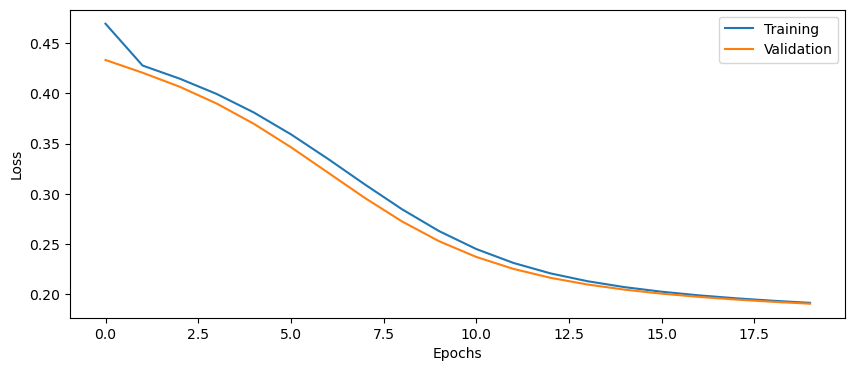

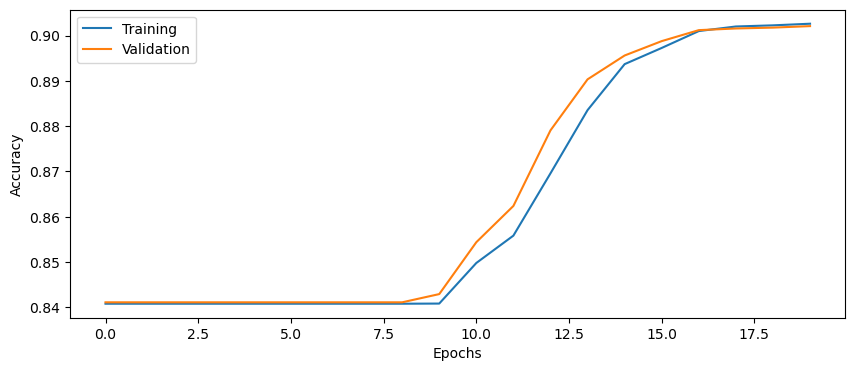

In [13]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

Answer: If we add several dense layers without activation function, the model will not be able to produce complex non-linear decision boundaries.

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

Answer: The weights in each dense layer i.e., kernel_initializer is by default set to 'glorot_uniform' also known as Xavier initialization, and the bias is initialzed as a 'zeros' vector.


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [14]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(Y), y = Y)

# Print the class weights
print(class_weights)
# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                1: class_weights[1]}
class_weights

[3.14144645 0.59464511]


{0: 3.1414464488332703, 1: 0.5946451138959964}

### 2 layers, 20 nodes, class weights

In [15]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model2 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 8ms/step - loss: 0.6731 - accuracy: 0.8630 - val_loss: 0.6440 - val_accuracy: 0.8767
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.8771 - val_loss: 0.5762 - val_accuracy: 0.8758
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.8791 - val_loss: 0.4889 - val_accuracy: 0.8796
Epoch 4/20
27/27 [==============================] - 0s 4ms/step - loss: 0.4352 - accuracy: 0.8800 - val_loss: 0.4083 - val_accuracy: 0.8804
Epoch 5/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8802 - val_loss: 0.3511 - val_accuracy: 0.8798
Epoch 6/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3061 - accuracy: 0.8802 - val_loss: 0.3174 - val_accuracy: 0.8798
Epoch 7/20
27/27 [==============================] - 0s 5ms/step - loss: 0.2741 - accuracy: 0.8802 - val_loss: 0.2993 - val_accuracy: 0.8797
Epoch 8/20
27/27 [==

In [16]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, batch_size=128)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 486us/step - loss: 0.2599 - accuracy: 0.8890
Test loss: 0.2599
Test accuracy: 0.8890


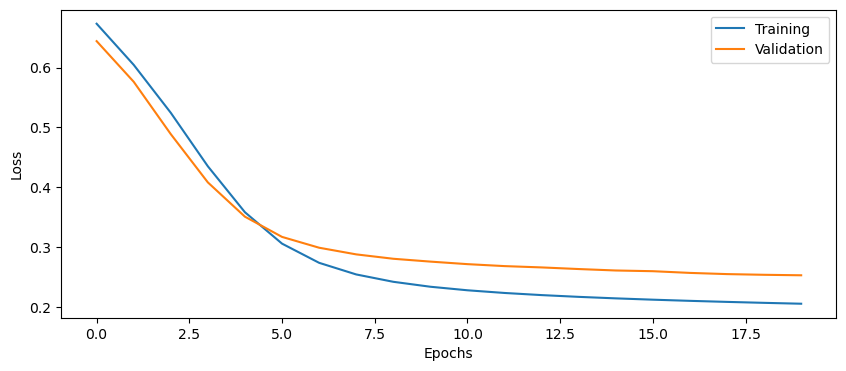

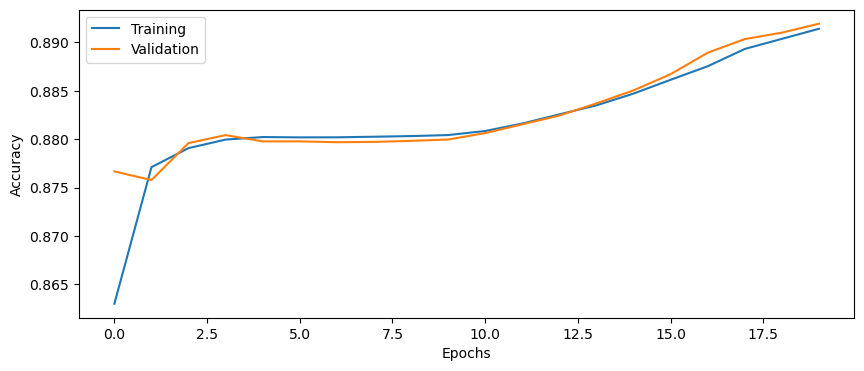

In [17]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Answer: This is because the CPU is not unlimited, and if the data is larger than the CPU memory, then streaming it from the hard-disk will take longer training times.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?

Answer: In each training epoch irrespective of the batch size, the weights will be updated once during the backward propagation phase of training the network. To calculate how many times weights are updated in total, we would require the total number of training samples.

Question 11: What limits how large the batch size can be?

Answer: The memory size of GPU typically limits how large the batch size can be. If GPU size is not enough, we can use the CPU memory to accomodate the batches.

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Answer: If the batch size is large and the learning rate is small then the training takes more time because the gradient descent algorithm would take longer time to reach the local minima. If the batch size is decreased, then the learning rate should also decreased so as to not overshoot the local minima.

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

Answer: The model with 4 dense layers and 50 nodes have 12351 total trainable parameters as compare to a model with 2 layers and 20 nodes per layer which has 2301 total trainable parameters.

### 4 layers, 20 nodes, class weights

In [18]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=20, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 9ms/step - loss: 0.6938 - accuracy: 0.4735 - val_loss: 0.6935 - val_accuracy: 0.1272
Epoch 2/20
27/27 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5382 - val_loss: 0.6942 - val_accuracy: 0.1541
Epoch 3/20
27/27 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.3569 - val_loss: 0.6933 - val_accuracy: 0.1351
Epoch 4/20
27/27 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5555 - val_loss: 0.6958 - val_accuracy: 0.1583
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4065 - val_loss: 0.6915 - val_accuracy: 0.8411
Epoch 6/20
27/27 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.6110 - val_loss: 0.6956 - val_accuracy: 0.1586
Epoch 7/20
27/27 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5298 - val_loss: 0.6954 - val_accuracy: 0.1586
Epoch 8/20
27/27 [==

In [19]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, batch_size=128)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 539us/step - loss: 0.6899 - accuracy: 0.8771
Test loss: 0.6899
Test accuracy: 0.8771


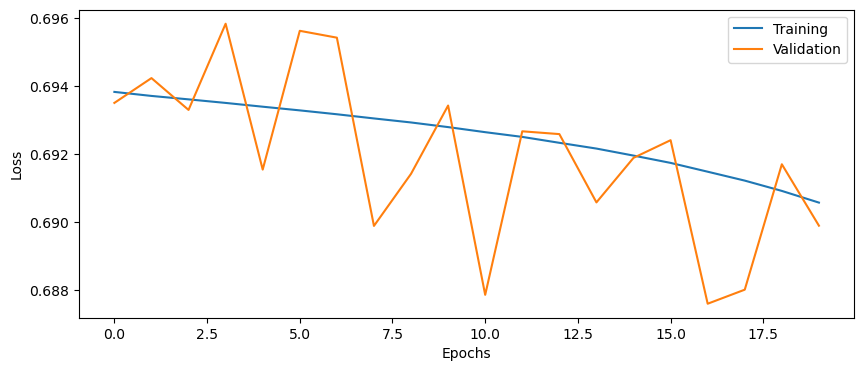

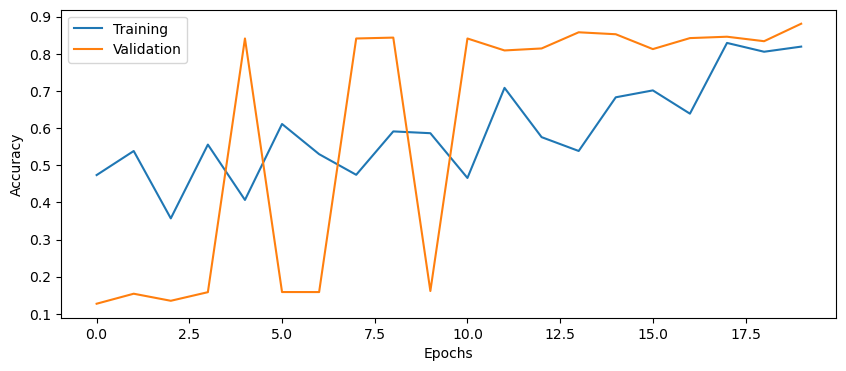

In [20]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [21]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=50, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 16ms/step - loss: 0.6603 - accuracy: 0.8712 - val_loss: 0.5993 - val_accuracy: 0.8801
Epoch 2/20
27/27 [==============================] - 0s 10ms/step - loss: 0.5459 - accuracy: 0.8805 - val_loss: 0.4998 - val_accuracy: 0.8796
Epoch 3/20
27/27 [==============================] - 0s 11ms/step - loss: 0.4399 - accuracy: 0.8803 - val_loss: 0.3994 - val_accuracy: 0.8797
Epoch 4/20
27/27 [==============================] - 0s 11ms/step - loss: 0.3476 - accuracy: 0.8803 - val_loss: 0.3350 - val_accuracy: 0.8797
Epoch 5/20
27/27 [==============================] - 0s 11ms/step - loss: 0.2886 - accuracy: 0.8804 - val_loss: 0.3019 - val_accuracy: 0.8798
Epoch 6/20
27/27 [==============================] - 0s 12ms/step - loss: 0.2567 - accuracy: 0.8804 - val_loss: 0.2839 - val_accuracy: 0.8798
Epoch 7/20
27/27 [==============================] - 0s 11ms/step - loss: 0.2395 - accuracy: 0.8805 - val_loss: 0.2742 - val_accuracy: 0.8800
Epoch 8/20
27

In [22]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, batch_size=128)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 535us/step - loss: 0.2509 - accuracy: 0.8943
Test loss: 0.2509
Test accuracy: 0.8943


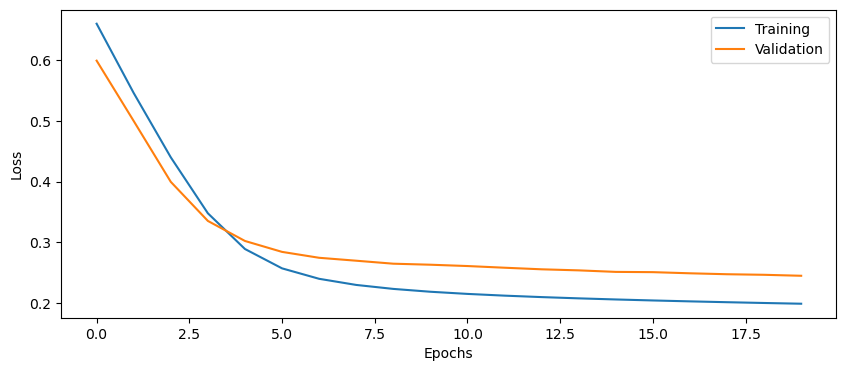

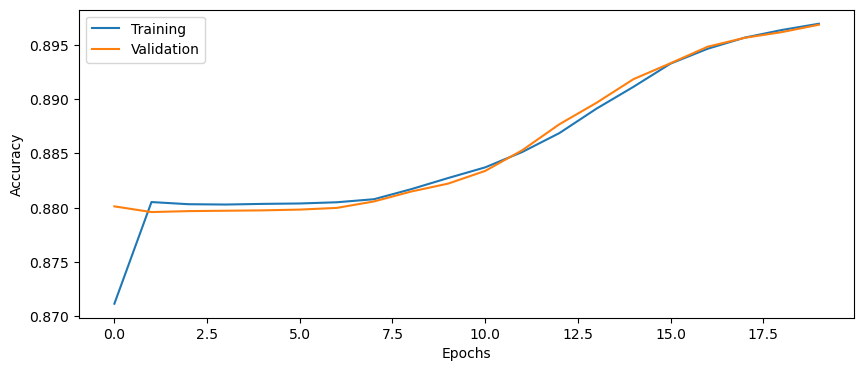

In [23]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [24]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 23ms/step - loss: 0.6940 - accuracy: 0.3889 - val_loss: 0.6933 - val_accuracy: 0.2085
Epoch 2/20
27/27 [==============================] - 0s 18ms/step - loss: 0.6920 - accuracy: 0.5368 - val_loss: 0.6945 - val_accuracy: 0.1671
Epoch 3/20
27/27 [==============================] - 0s 16ms/step - loss: 0.6915 - accuracy: 0.5476 - val_loss: 0.6923 - val_accuracy: 0.8788
Epoch 4/20
27/27 [==============================] - 1s 19ms/step - loss: 0.6910 - accuracy: 0.6517 - val_loss: 0.6898 - val_accuracy: 0.8785
Epoch 5/20
27/27 [==============================] - 0s 17ms/step - loss: 0.6904 - accuracy: 0.6535 - val_loss: 0.6842 - val_accuracy: 0.8436
Epoch 6/20
27/27 [==============================] - 0s 18ms/step - loss: 0.6898 - accuracy: 0.8699 - val_loss: 0.6941 - val_accuracy: 0.1600
Epoch 7/20
27/27 [==============================] - 0s 16ms/step - loss: 0.6891 - accuracy: 0.7329 - val_loss: 0.6894 - val_accuracy: 0.8834
Epoch 8/20
27

In [25]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, batch_size=128)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 553us/step - loss: 0.6367 - accuracy: 0.8848
Test loss: 0.6367
Test accuracy: 0.8848


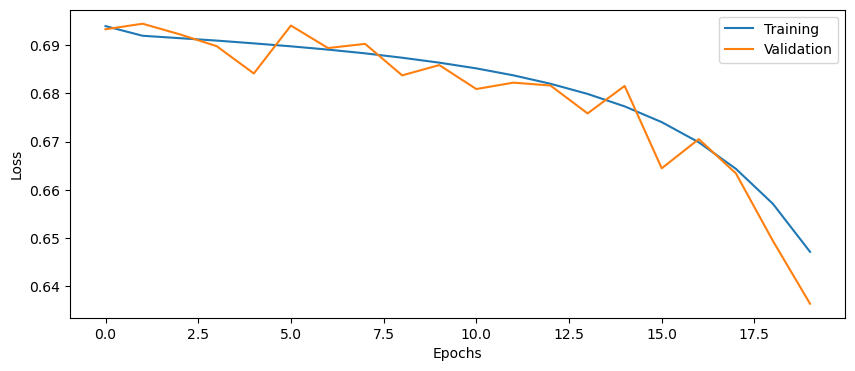

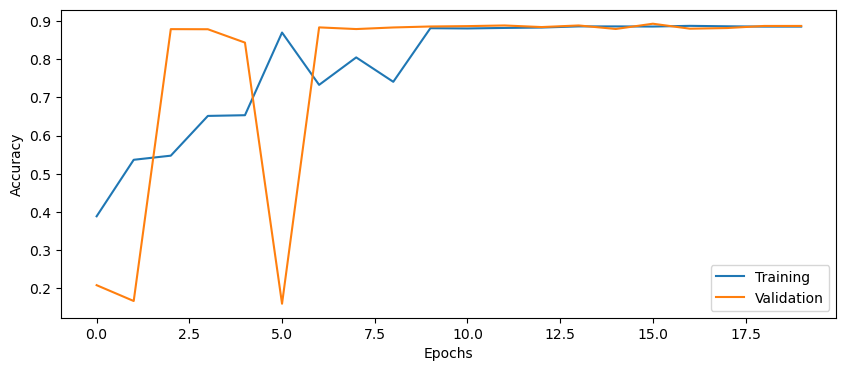

In [26]:
plot_results(history5)

In [27]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                4650      
                                                                 
 activation_10 (Activation)  (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 activation_11 (Activation)  (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 activation_12 (Activation)  (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 50)               

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

Answer: When training deep neural networks, there may be issues of vanishing or exploding gradients, where the gradients become too small or large to be used with activation functions. Therfore, Batch Normalisation can be used to normalise these gradients before passing them through the activation functions.

### 2 layers, 20 nodes, class weights, batch normalization

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model6 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=True, use_dropout=False, use_custom_dropout=False)

history6 = model6.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 15ms/step - loss: 0.3201 - accuracy: 0.8687 - val_loss: 0.4293 - val_accuracy: 0.8411
Epoch 2/20
27/27 [==============================] - 0s 6ms/step - loss: 0.2372 - accuracy: 0.8980 - val_loss: 0.4012 - val_accuracy: 0.8411
Epoch 3/20
27/27 [==============================] - 0s 6ms/step - loss: 0.2128 - accuracy: 0.9059 - val_loss: 0.3930 - val_accuracy: 0.8411
Epoch 4/20
27/27 [==============================] - 0s 6ms/step - loss: 0.2007 - accuracy: 0.9093 - val_loss: 0.3844 - val_accuracy: 0.8411
Epoch 5/20
27/27 [==============================] - 0s 6ms/step - loss: 0.1935 - accuracy: 0.9110 - val_loss: 0.3731 - val_accuracy: 0.8411
Epoch 6/20
27/27 [==============================] - 0s 6ms/step - loss: 0.1888 - accuracy: 0.9120 - val_loss: 0.3573 - val_accuracy: 0.8411
Epoch 7/20
27/27 [==============================] - 0s 6ms/step - loss: 0.1854 - accuracy: 0.9127 - val_loss: 0.3352 - val_accuracy: 0.8411
Epoch 8/20
27/27 [=

In [29]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, batch_size=128) 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 576us/step - loss: 0.1871 - accuracy: 0.9139
Test loss: 0.1871
Test accuracy: 0.9139


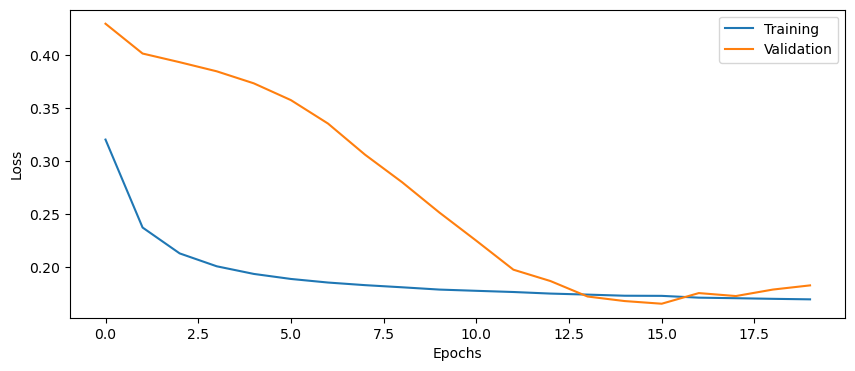

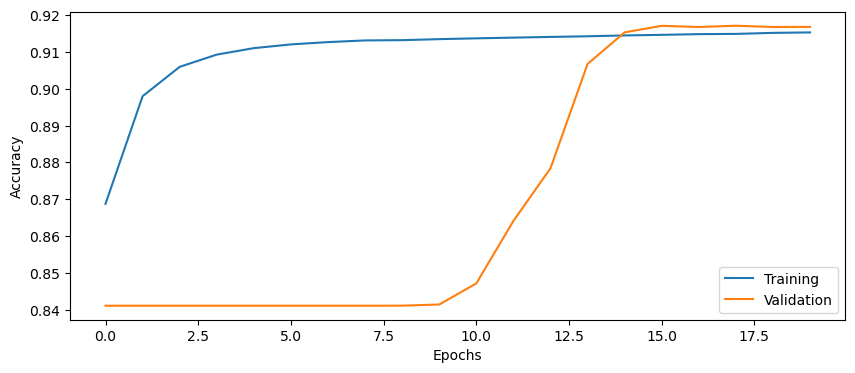

In [30]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [31]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model7 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, 
                   act_fun='ReLU', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

history7 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs,
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 0s 7ms/step - loss: 0.3987 - accuracy: 0.8674 - val_loss: 0.3456 - val_accuracy: 0.8837
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.2405 - accuracy: 0.8881 - val_loss: 0.2749 - val_accuracy: 0.8920
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 0.2101 - accuracy: 0.8944 - val_loss: 0.2564 - val_accuracy: 0.8968
Epoch 4/20
27/27 [==============================] - 0s 5ms/step - loss: 0.1990 - accuracy: 0.8978 - val_loss: 0.2476 - val_accuracy: 0.8991
Epoch 5/20
27/27 [==============================] - 0s 6ms/step - loss: 0.1924 - accuracy: 0.8997 - val_loss: 0.2427 - val_accuracy: 0.9007
Epoch 6/20
27/27 [==============================] - 0s 5ms/step - loss: 0.1878 - accuracy: 0.9011 - val_loss: 0.2369 - val_accuracy: 0.9020
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 0.1845 - accuracy: 0.9025 - val_loss: 0.2319 - val_accuracy: 0.9036
Epoch 8/20
27/27 [==

In [32]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, batch_size=128) 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 486us/step - loss: 0.2224 - accuracy: 0.9107
Test loss: 0.2224
Test accuracy: 0.9107


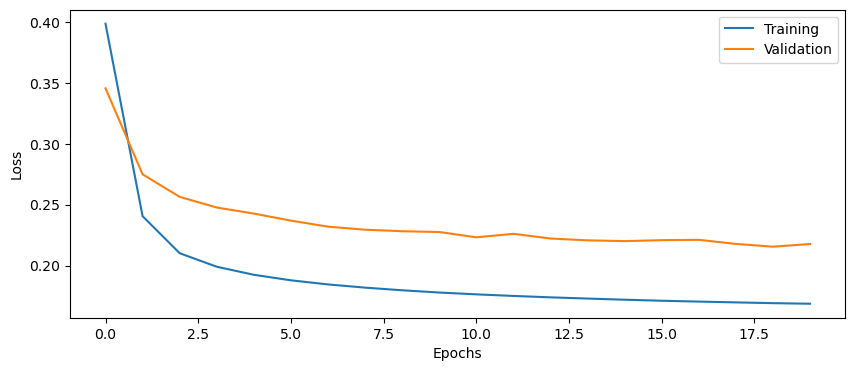

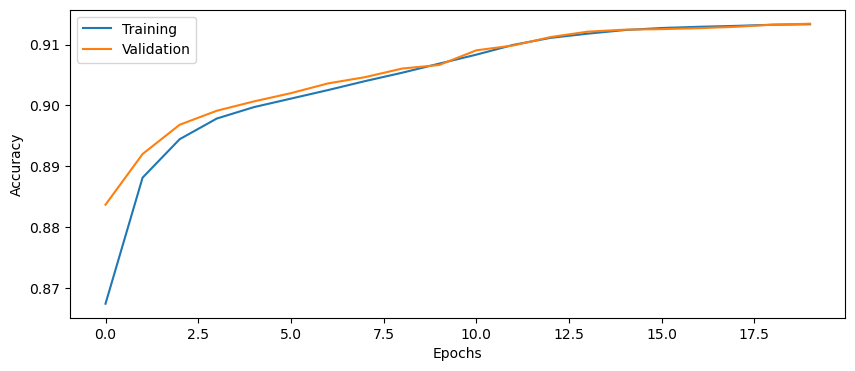

In [33]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [34]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, 
                   act_fun='sigmoid', optimizer='Adam', learning_rate=0.1, 
                   use_bn=False, use_dropout=False, use_custom_dropout=False)

history8 = model8.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 8ms/step - loss: 0.2349 - accuracy: 0.8929 - val_loss: 0.2341 - val_accuracy: 0.9117
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.1721 - accuracy: 0.9133 - val_loss: 0.2204 - val_accuracy: 0.9145
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9160 - val_loss: 0.2164 - val_accuracy: 0.9167
Epoch 4/20
27/27 [==============================] - 0s 4ms/step - loss: 0.1632 - accuracy: 0.9168 - val_loss: 0.2016 - val_accuracy: 0.9169
Epoch 5/20
27/27 [==============================] - 0s 4ms/step - loss: 0.1636 - accuracy: 0.9166 - val_loss: 0.2059 - val_accuracy: 0.9172
Epoch 6/20
27/27 [==============================] - 0s 5ms/step - loss: 0.1600 - accuracy: 0.9182 - val_loss: 0.2081 - val_accuracy: 0.9190
Epoch 7/20
27/27 [==============================] - 0s 5ms/step - loss: 0.1589 - accuracy: 0.9194 - val_loss: 0.1993 - val_accuracy: 0.9194
Epoch 8/20
27/27 [==

In [35]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, batch_size=128) 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 508us/step - loss: 0.1634 - accuracy: 0.9227
Test loss: 0.1634
Test accuracy: 0.9227


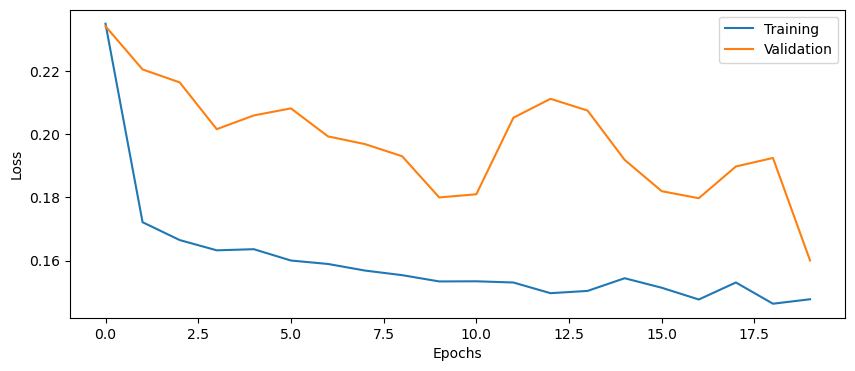

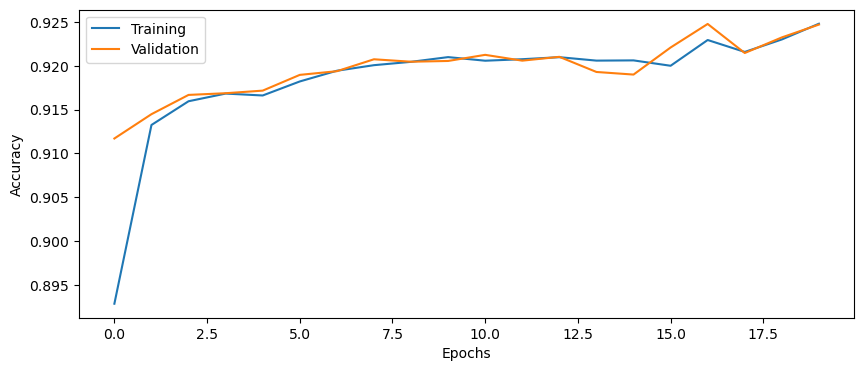

In [36]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Answer: Ideally, after adding dropout, the generalising power(validation accuracy) of the model increases in all the epochs since dropout has a regularizing effect.

Question 16: How does the test accuracy change when adding dropout?

Answer: The effect of overfitting is reduced i.e., test accuracy increases when adding dropout due to its regularizing nature.

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, 
                   act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
                   use_bn=False, use_dropout=True, use_custom_dropout=False)

history9 = model9.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                      validation_data = (Xval, Yval), class_weight=class_weights)

Epoch 1/20
27/27 [==============================] - 1s 10ms/step - loss: 0.7144 - accuracy: 0.5677 - val_loss: 0.6419 - val_accuracy: 0.8925
Epoch 2/20
27/27 [==============================] - 0s 7ms/step - loss: 0.6644 - accuracy: 0.5863 - val_loss: 0.6007 - val_accuracy: 0.8961
Epoch 3/20
27/27 [==============================] - 0s 7ms/step - loss: 0.6269 - accuracy: 0.6386 - val_loss: 0.5546 - val_accuracy: 0.8930
Epoch 4/20
27/27 [==============================] - 0s 6ms/step - loss: 0.5898 - accuracy: 0.6837 - val_loss: 0.5046 - val_accuracy: 0.8891
Epoch 5/20
27/27 [==============================] - 0s 6ms/step - loss: 0.5488 - accuracy: 0.7242 - val_loss: 0.4537 - val_accuracy: 0.8878
Epoch 6/20
27/27 [==============================] - 0s 7ms/step - loss: 0.5085 - accuracy: 0.7582 - val_loss: 0.4062 - val_accuracy: 0.8864
Epoch 7/20
27/27 [==============================] - 0s 7ms/step - loss: 0.4714 - accuracy: 0.7852 - val_loss: 0.3688 - val_accuracy: 0.8850
Epoch 8/20
27/27 [=

In [38]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, batch_size=128) 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 492us/step - loss: 0.2772 - accuracy: 0.8854
Test loss: 0.2772
Test accuracy: 0.8854


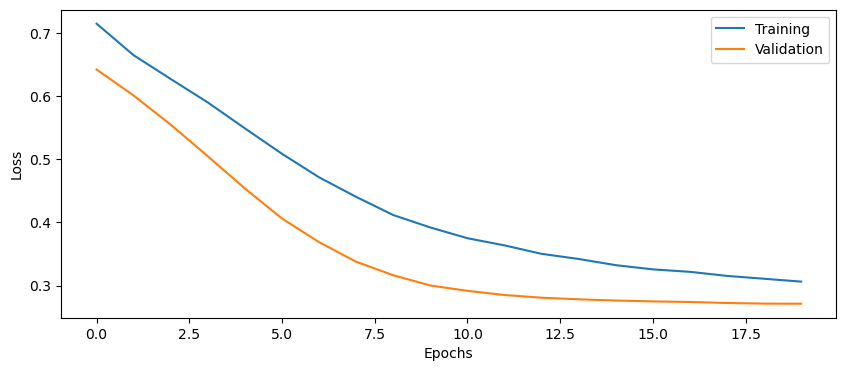

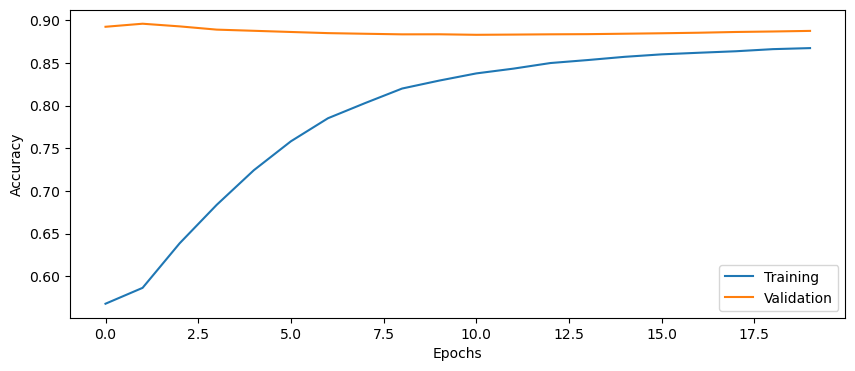

In [39]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

Answer: The highest classification accuracy that could be achieved is around 91% with the following configuration: 

batch_size = 5000,
epochs = 20,
n_layers = 5,
n_nodes=60,
act_fun='sigmoid',
optimizer='Adam',
learning_rate=0.001,
use_bn=True,
use_dropout=True

In [40]:
# Find your best configuration for the DNN
batch_size = 5000
epochs = 20
input_shape = Xtrain.shape
# Build and train DNN
model10 = build_DNN(input_shape=input_shape, n_layers=5, n_nodes=60, 
                    act_fun='sigmoid', optimizer='Adam', learning_rate=0.001, 
                    use_bn=True, use_dropout=True, use_custom_dropout=False)

history10 = model10.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                        validation_data = (Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 3s 38ms/step - loss: 0.7451 - accuracy: 0.5419 - val_loss: 0.4089 - val_accuracy: 0.8941
Epoch 2/20
54/54 [==============================] - 2s 34ms/step - loss: 0.3820 - accuracy: 0.7922 - val_loss: 0.2391 - val_accuracy: 0.8831
Epoch 3/20
54/54 [==============================] - 2s 34ms/step - loss: 0.3001 - accuracy: 0.8650 - val_loss: 0.2507 - val_accuracy: 0.8844
Epoch 4/20
54/54 [==============================] - 2s 34ms/step - loss: 0.2640 - accuracy: 0.8808 - val_loss: 0.2455 - val_accuracy: 0.8951
Epoch 5/20
54/54 [==============================] - 2s 35ms/step - loss: 0.2337 - accuracy: 0.8937 - val_loss: 0.2442 - val_accuracy: 0.9005
Epoch 6/20
54/54 [==============================] - 2s 35ms/step - loss: 0.2178 - accuracy: 0.8987 - val_loss: 0.2406 - val_accuracy: 0.9043
Epoch 7/20
54/54 [==============================] - 2s 35ms/step - loss: 0.2059 - accuracy: 0.9024 - val_loss: 0.2302 - val_accuracy: 0.9076
Epoch 8/20
54

In [41]:
model10.summary(100)

Model: "sequential_9"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 dense_31 (Dense)                            (None, 60)                              5580           
                                                                                                    
 activation_22 (Activation)                  (None, 60)                              0              
                                                                                                    
 dropout_2 (Dropout)                         (None, 60)                              0              
                                                                                                    
 batch_normalization_2 (BatchNormalization)  (None, 60)                              240            
                                                                     

In [42]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, batch_size=128) 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 0s 792us/step - loss: 0.2239 - accuracy: 0.9136
Test loss: 0.2239
Test accuracy: 0.9136


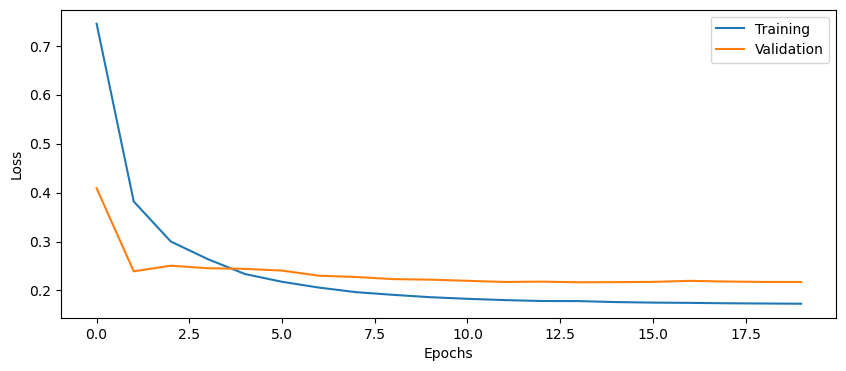

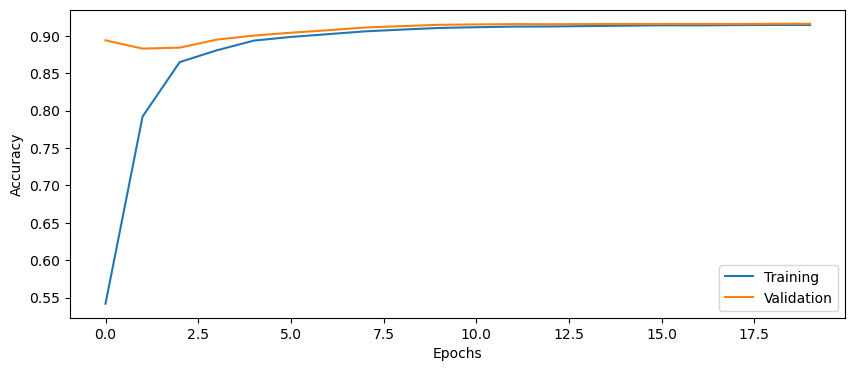

In [43]:
plot_results(history10)

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

Answer: As calculated below: 

The mean of test accuracies using custom dropout is 0.9119279032945633

The standard deviation of test accuracies using custom dropout is 0.00018234468167098285

In [44]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [45]:
# Your best training parameters
batch_size = 5000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model11 = build_DNN(input_shape=input_shape, n_layers=5, n_nodes=60, 
                    act_fun='sigmoid', optimizer='Adam', learning_rate=0.001, 
                    use_bn=True, use_dropout=False, use_custom_dropout=True)

history11 = model11.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, 
                        validation_data = (Xval, Yval), class_weight=class_weights)
 

Epoch 1/20
54/54 [==============================] - 3s 43ms/step - loss: 0.7515 - accuracy: 0.5602 - val_loss: 0.5909 - val_accuracy: 0.6916
Epoch 2/20
54/54 [==============================] - 2s 42ms/step - loss: 0.3795 - accuracy: 0.8037 - val_loss: 0.2882 - val_accuracy: 0.8755
Epoch 3/20
54/54 [==============================] - 2s 41ms/step - loss: 0.3020 - accuracy: 0.8661 - val_loss: 0.2652 - val_accuracy: 0.8810
Epoch 4/20
54/54 [==============================] - 2s 42ms/step - loss: 0.2685 - accuracy: 0.8787 - val_loss: 0.2592 - val_accuracy: 0.8862
Epoch 5/20
54/54 [==============================] - 2s 41ms/step - loss: 0.2437 - accuracy: 0.8858 - val_loss: 0.2505 - val_accuracy: 0.8946
Epoch 6/20
54/54 [==============================] - 2s 40ms/step - loss: 0.2218 - accuracy: 0.8953 - val_loss: 0.2434 - val_accuracy: 0.9010
Epoch 7/20
54/54 [==============================] - 2s 41ms/step - loss: 0.2085 - accuracy: 0.9003 - val_loss: 0.2355 - val_accuracy: 0.9051
Epoch 8/20
54

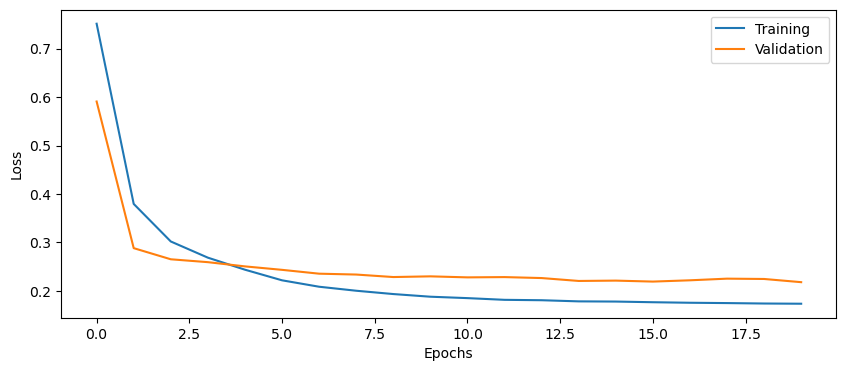

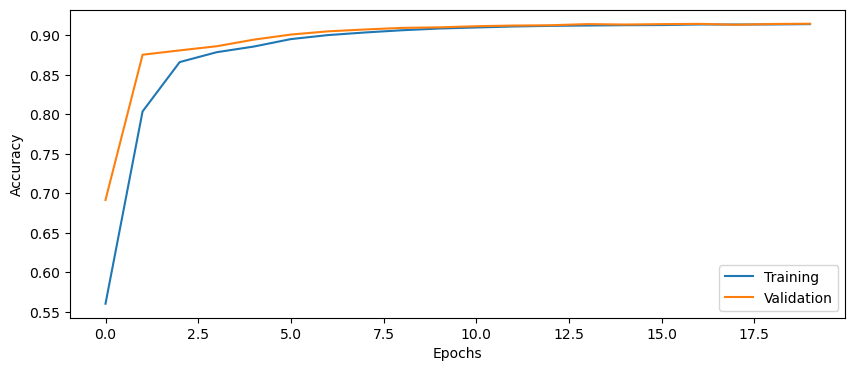

In [46]:
plot_results(history11)

In [47]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest, batch_size=128)
                       
print('Test accuracy: %.4f' % score[1])

448/448 [==============================] - 1s 2ms/step - loss: 0.2242 - accuracy: 0.9117
Test accuracy: 0.9117


In [48]:
# Run the testing 100 times, and save the accuracies in an array
accuracy = np.array([])
for i in range(100):
    score = model11.evaluate(Xtest, Ytest, batch_size=128)
    accuracy = np.append(accuracy, score[1])
# Calculate and print mean and std of accuracies



448/448 [==============================] - 1s 2ms/step - loss: 0.2242 - accuracy: 0.9121


In [49]:
print('The mean of test accuracies using custom dropout is', np.mean(accuracy))
print('The standard deviation of test accuracies using custom dropout is', np.std(accuracy))

The mean of test accuracies using custom dropout is 0.9119279032945633
The standard deviation of test accuracies using custom dropout is 0.00018234468167098285


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Answer: As calculated below:

The mean of test accuracies using 10-fold CV is 0.9157089412212371

The standard deviation of test accuracies using 10-fold CV is 0.0013224688345090635

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

Answer: The main advantage of dropout compared to CV for estimating test uncertainty is its computational efficiency and simplicity. This is because training with dropout is computationally efficient as compared to CV where we train multiple models on subsets of data. 

In [50]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
accuracies = []
batch_size = 5000
epochs = 20

# Loop over cross validation folds
for train_indx, test_indx in cv.split(X_new, Y):
    x_train_cv, x_test_cv = X_new[train_indx], X_new[test_indx]
    y_train_cv, y_test_cv = Y[train_indx], Y[test_indx]
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                      classes = np.unique(y_train_cv), 
                                                      y = y_train_cv)
    class_weights = {0: class_weights[0], 
                     1: class_weights[1]}
    # Rebuild the DNN model, to not continue training on the previously trained model
    input_shape_cv = x_train_cv.shape
    cv_model = build_DNN(input_shape=input_shape_cv, n_layers=5, n_nodes=60, 
                         act_fun='sigmoid', optimizer='Adam', learning_rate=0.001, 
                         use_bn=True, use_dropout=True, use_custom_dropout=False)
    # Fit the model with training set and class weights for this fold
    history_cv = cv_model.fit(x_train_cv, y_train_cv,epochs=epochs, 
                              batch_size=batch_size, class_weight=class_weights)
    # Evaluate the model using the test set for this fold
    score_cv = cv_model.evaluate(x_test_cv, y_test_cv, batch_size=128)
    # Save the test accuracy in an array
    accuracies = np.append(accuracies, score_cv[1])
# Calculate and print mean and std of accuracies



Epoch 1/20
69/69 [==============================] - 3s 31ms/step - loss: 0.6734 - accuracy: 0.6004
Epoch 2/20
69/69 [==============================] - 2s 32ms/step - loss: 0.3369 - accuracy: 0.8257
Epoch 3/20
69/69 [==============================] - 2s 32ms/step - loss: 0.2741 - accuracy: 0.8714
Epoch 4/20
69/69 [==============================] - 2s 32ms/step - loss: 0.2402 - accuracy: 0.8838
Epoch 5/20
69/69 [==============================] - 2s 32ms/step - loss: 0.2141 - accuracy: 0.8963
Epoch 6/20
69/69 [==============================] - 2s 32ms/step - loss: 0.1995 - accuracy: 0.9027
Epoch 7/20
69/69 [==============================] - 3s 43ms/step - loss: 0.1909 - accuracy: 0.9075
Epoch 8/20
69/69 [==============================] - 3s 44ms/step - loss: 0.1856 - accuracy: 0.9094
Epoch 9/20
69/69 [==============================] - 3s 44ms/step - loss: 0.1819 - accuracy: 0.9109
Epoch 10/20
69/69 [==============================] - 3s 44ms/step - loss: 0.1793 - accuracy: 0.9115
Epoch 11/

In [51]:
print('The mean of test accuracies using 10-fold CV is', np.mean(accuracies))
print('The standard deviation of test accuracies using 10-fold CV is', np.std(accuracies))

The mean of test accuracies using 10-fold CV is 0.9157089412212371
The standard deviation of test accuracies using 10-fold CV is 0.0013224688345090635


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

Answer: To use the DNN in this lab for regression, we need to make the following changes:

Change the output layer activation function to 'linear'.

Change the loss function from binary cross entropy to one of the regression loss function such as mean squared error or mean absolute error. 

Change the metrics from classification 'accuracy' to 'mse' or 'mae'.


## Report

Send in this jupyter notebook, with answers to all questions.